# Combining InSAR Data From Different Tracks and Orbits

## Setup

In [1]:
%matplotlib inline
import glob
import numpy as np
import sys
import shutil
from pathlib import Path
from skimage import morphology

import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [2]:
cd ~/insar/combined

/home/micromamba/insar/combined


## Set paths

In [3]:
Path('../asc_lower').resolve()

PosixPath('/home/micromamba/insar/asc_lower')

In [4]:
data_paths = {'asc_lower':Path('../asc_lower').resolve(),
             'asc_upper':Path('../asc_upper').resolve(),
             'desc_lower':Path('../desc_lower').resolve(),
             'desc_upper':Path('../desc_upper').resolve()}

In [41]:
data_paths = {
             # 'asc_lower':Path('../asc_lower').resolve(),
             # 'asc_upper':Path('../asc_upper').resolve(),
             # 'desc_lower':Path('../desc_lower').resolve(),
             'desc_upper':Path('../desc_upper').resolve()}

## Create eroded mask file and mask velocity datasets

In [64]:
for name in data_paths:
    p = data_paths[name]

    mask_name = f'maskTempCoh_{name.replace("_","")}_erd.h5'
    
    # Find files
    vels = list(p.glob('velocity*h5'))
    tcoh_mask = list(p.glob('maskTempCoh_*h5'))[0]

    # Create new mask
    data, atr = readfile.read(tcoh_mask)
    erd = (morphology.binary_erosion(morphology.remove_small_holes(data,10), morphology.square(51))).astype(int)
    writefile.write({'mask':erd},mask_name,ref_file=tcoh_mask)
    
    # Mask velocity files
    for v in vels:
        name, ext = v.name.split('.')
        vel_name = f'{name}_mask.{ext}'
        !mask.py {str(v)} -m {mask_name} -o {vel_name}


delete exsited file: maskTempCoh_asclower_erd.h5
create HDF5 file: maskTempCoh_asclower_erd.h5 with w mode
create dataset /mask of int64      in size of (2394, 4120)         with compression=None
finished writing to maskTempCoh_asclower_erd.h5
masking velocity    from /home/micromamba/insar/asc_lower/velocity_asclower_2020.h5 ...
masking velocityStd from /home/micromamba/insar/asc_lower/velocity_asclower_2020.h5 ...
delete exsited file: velocity_asclower_2020_mask.h5
create HDF5 file: velocity_asclower_2020_mask.h5 with w mode
create dataset /velocity    of float32    in size of (2394, 4120)         with compression=None
create dataset /velocityStd of float32    in size of (2394, 4120)         with compression=None
finished writing to velocity_asclower_2020_mask.h5
Done.
masking velocity    from /home/micromamba/insar/asc_lower/velocity_asclower_2019.h5 ...
masking velocityStd from /home/micromamba/insar/asc_lower/velocity_asclower_2019.h5 ...
delete exsited file: velocity_asclower_201

## Merge ascending and descending files by year

In [94]:
from itertools import product

tracks = ['asc','desc']
years = [2019,2020,2021]

In [94]:
for track, year in product(tracks,years):
    pattern = f'velocity_{track}*_{year}_mask.h5'
    vel_name = f'velocity_{track}_{year}.h5'
    std_name = f'std_{track}_{year}.h5'

    # plotting results needs to be disabled at line 279 of image_stitch.py
    !image_stitch.py {pattern} -o {vel_name} -d velocity --no-offset
    !image_stitch.py {pattern} -o {std_name} -d velocityStd --no-offset

files to be stitched:
	velocity_asclower_2019_mask.h5
	velocity_ascupper_2019_mask.h5
read data from file: velocity_asclower_2019_mask.h5
--------------------------------------------------
read data from file: velocity_ascupper_2019_mask.h5
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (2572, 4782)
--------------------------------------------------
delete exsited file: velocity_asc_2019.h5
create HDF5 file: velocity_asc_2019.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_asc_2019.h5
files to be stitched:
	velocity_asclower_2019_mask.h5
	velocity_ascupper_2019_mask.h5
read data from file: velocity_asclower_2019_mask.h5
--------------------------------------------------
read data from file: velocity_ascupper_2019_mask.h5
stitching ...
grab corners of input matrices
calculate cor

## Project from ascending/descending orbit to E-W/Up-Down

In [104]:
for year in years:
    asc_vel = f'velocity_asc_{year}.h5'
    desc_vel = f'velocity_desc_{year}.h5'
    
    asc_std = f'std_asc_{year}.h5'
    desc_std = f'std_desc_{year}.h5'
    
    up_vel = f'velocity_up_{year}.h5'
    ew_vel = f'velocity_ew_{year}.h5'

    up_std = f'std_up_{year}.h5'    
    ew_std = f'std_ew_{year}.h5'

    !asc_desc2horz_vert.py {asc_vel} {desc_vel} -o {ew_vel} {up_vel} --max-ref-yx-diff 10000
    !asc_desc2horz_vert.py {asc_std} {desc_std} -o {ew_std} {up_std} --max-ref-yx-diff 10000

---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 462640.0)
read from file: velocity_asc_2019.h5
read from file: velocity_desc_2019.h5
---------------------
get design matrix
LOS incidence angle: 35.66832225719844 deg
LOS azimuth angle: 103.83512539999998 deg
LOS incidence angle: 35.77095461818939 deg
LOS azimuth angle: -103.77717740000003 deg
project asc/desc into horz/vert direction
---------------------
writing horizontal component to file: velocity_ew_2019.h5
create HDF5 file: velocity_ew_2019.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_ew_2019.h5
writing   vertical component to file: velocity_up_2019.h5
create HDF5 file: velocity_up_2019.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_up_2019.h5
Done.
---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 

## Prep temporal coherence

In [121]:
for track, year in product(tracks,years):

    pattern = f'../{track}*/temporalCoherence_{track}*_{year}.h5'
    coh_name = f'temporalCoherence_{track}_{year}.h5'
    image1, image2 = [str(x.resolve()) for x in Path().glob(pattern)]

    # plotting results needs to be disabled at line 279 of image_stitch.py
    !image_stitch.py {image1} {image2} -o {coh_name} --no-offset

files to be stitched:
	/home/micromamba/insar/asc_lower/temporalCoherence_asclower_2019.h5
	/home/micromamba/insar/asc_upper/temporalCoherence_ascupper_2019.h5
read data from file: /home/micromamba/insar/asc_lower/temporalCoherence_asclower_2019.h5
--------------------------------------------------
read data from file: /home/micromamba/insar/asc_upper/temporalCoherence_ascupper_2019.h5
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (2572, 4782)
--------------------------------------------------
create HDF5 file: temporalCoherence_asc_2019.h5 with w mode
create dataset /temporalCoherence of float32    in size of (2572, 4782)         with compression=None
finished writing to temporalCoherence_asc_2019.h5
files to be stitched:
	/home/micromamba/insar/asc_lower/temporalCoherence_asclower_2020.h5
	/home/micromamba/insar/asc_upper/temporalCoherence_ascupper_2020.h5
read d

In [108]:
ls ../asc*/

'/home/micromamba/insar/combined'

In [105]:
!image_stitch.py -h

usage: image_stitch.py [-h] -o OUTFILE [--no-offset] [--nodisplay]
                       file1 file2 [file2 ...]

Stitch >=2 geocoded datasets sharing common area into one.
	Function automatically finds the common area and calculates
	the average offset between the two velocity.

positional arguments:
  file1                 file to stitch
  file2                 file(s) to stitch

optional arguments:
  -h, --help            show this help message and exit
  -o OUTFILE, --output OUTFILE
                        output file name
  --no-offset           Do not apply offset if data sets are merely to be stitched and no adjustment of values needs to be made (i.e., for two coherence maps), use this flag
  --nodisplay           do not display the result ploting.

example:
  image_stitch.py  vel_AlosAT42*.h5  -o vel_AlosA.h5
  image_stitch.py  vel_AlosAT422.h5  vel_AlosAT423.h5  vel_AlosAT424.h5  vel_AlosAT425.h5  -o vel_AlosA.h5


## Export to geotiffs

In [75]:
files = list(cwd.glob('velocity_*[ewup]_20*[0129].h5'))

In [81]:
for f in files:
    out = f.name.split('.')[0] + '.tif'
    !save_gdal.py {str(f)} -d 'velocity' -o {out}

read metadata from file: velocity_up_2019.h5
read data     from file: velocity_up_2019.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/insar/combined/velocity_up_2019.tif
read metadata from file: velocity_ew_2019.h5
read data     from file: velocity_ew_2019.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/insar/combined/velocity_ew_2019.tif
read metadata from file: velocity_up_2020.h5
read data     from file: velocity_up_2020.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to ra

In [ ]:
# 1. Extract the common area of two input files
# Basic info
atr_list = []
for fname in fnames:
    atr_list.append(readfile.read_attribute(fname, datasetName=dsname))

# Common AOI in lalo
west, east, south, north = get_overlap_lalo(atr_list[0], atr_list[1])
lon_step = float(atr_list[0]['X_STEP'])
lat_step = float(atr_list[0]['Y_STEP'])
width = int(round((east - west) / lon_step))
length = int(round((south - north) / lat_step))
print('common area in SNWE: {}'.format((south, north, west, east)))

In [ ]:
# 2. Read LOS data in common AOI
dLOS_list = []
for i in range(len(fnames)):
    fname = fnames[i]
    atr = readfile.read_attribute(fname, datasetName=dsname)

    # get box2read for the current file
    coord = ut.coordinate(atr)
    x0 = coord.lalo2yx(west, coord_type='lon')
    y0 = coord.lalo2yx(north, coord_type='lat')
    box = (x0, y0, x0 + width, y0 + length)

    # read
    dLOS_list.append(readfile.read(fname, box=box, datasetName=dsname)[0])

    # msg
    msg = 'read '
    if dsname:
        msg += '{} '.format(dsname)
    msg += 'from file: {}'.format(fname)
    print(msg)

In [ ]:
# 1. Extract the common area of two input files
# Basic info
atr_list = []
for fname in fnames:
    atr_list.append(readfile.read_attribute(fname, datasetName=dsname))

# Common AOI in lalo
west, east, south, north = get_overlap_lalo(atr_list[0], atr_list[1])
lon_step = float(atr_list[0]['X_STEP'])
lat_step = float(atr_list[0]['Y_STEP'])
width = int(round((east - west) / lon_step))
length = int(round((south - north) / lat_step))
print('common area in SNWE: {}'.format((south, north, west, east)))

In [ ]:
# 2. Read LOS data in common AOI
dLOS_list = []
for i in range(len(fnames)):
    fname = fnames[i]
    atr = readfile.read_attribute(fname, datasetName=dsname)

    # get box2read for the current file
    coord = ut.coordinate(atr)
    x0 = coord.lalo2yx(west, coord_type='lon')
    y0 = coord.lalo2yx(north, coord_type='lat')
    box = (x0, y0, x0 + width, y0 + length)

    # read
    dLOS_list.append(readfile.read(fname, box=box, datasetName=dsname)[0])

    # msg
    msg = 'read '
    if dsname:
        msg += '{} '.format(dsname)
    msg += 'from file: {}'.format(fname)
    print(msg)

In [95]:
files = []
for name in data_paths:
    short = name.replace('_','')
    pattern = f'temporalCoherence_{short}*.h5'
    files += list(data_paths[name].glob(pattern))

In [100]:
!ls

maskTempCoh_asclower_erd.h5	velocity_asclower_2021_mask.h5
maskTempCoh_ascupper_erd.h5	velocity_ascupper_2019_mask.h5
maskTempCoh_desclower_erd.h5	velocity_ascupper_2020_mask.h5
maskTempCoh_descupper_erd.h5	velocity_ascupper_2021_mask.h5
std_asc_2019.h5			velocity_desc_2019.h5
std_asc_2020.h5			velocity_desc_2020.h5
std_asc_2021.h5			velocity_desc_2021.h5
std_desc_2019.h5		velocity_desclower_2019_mask.h5
std_desc_2020.h5		velocity_desclower_2020_mask.h5
std_desc_2021.h5		velocity_desclower_2021_mask.h5
std_ew_2019.h5			velocity_descupper_2019_mask.h5
std_ew_2020.h5			velocity_descupper_2020_mask.h5
std_ew_2021.h5			velocity_descupper_2021_mask.h5
std_up_2019.h5			velocity_ew_2019.h5
std_up_2020.h5			velocity_ew_2019_mask.h5
std_up_2021.h5			velocity_ew_2020.h5
velocity_asc_2019.h5		velocity_ew_2021.h5
velocity_asc_2020.h5		velocity_up_2019.h5
velocity_asc_2021.h5		velocity_up_2020.h5
velocity_asclower_2019_mask.h5	velocity_up_2021.h5
velocity_asclower_2020_mask.h5


In [93]:
for name in data_paths:
    short = name.replace('_','')
    pattern = f'temporalCoherence_{short}*.h5'
    files = list(data_paths[name].glob(pattern))
    
    for f in files:
        out = f.name.split('.')[0] + '.tif'
        !save_gdal.py {str(f)} -o {out}

read metadata from file: /home/micromamba/insar/asc_lower/temporalCoherence_asclower_2020.h5
read data     from file: /home/micromamba/insar/asc_lower/temporalCoherence_asclower_2020.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2394, 4120
raster transform info: (297840.0, 40.0, 0, 5645840.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/insar/combined/temporalCoherence_asclower_2020.tif
read metadata from file: /home/micromamba/insar/asc_lower/temporalCoherence_asclower_2019.h5
read data     from file: /home/micromamba/insar/asc_lower/temporalCoherence_asclower_2019.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2394, 4120
raster transform info: (297840.0, 40.0, 0, 5645840.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/insar/combined/temporalCoherence_asclower_2019.tif
read metadata from file: /home/micro

In [92]:
paths

[PosixPath('/home/micromamba/insar/desc_upper/temporalCoherence_descupper_2020.h5'),
 PosixPath('/home/micromamba/insar/desc_upper/temporalCoherence_descupper_2021.h5'),
 PosixPath('/home/micromamba/insar/desc_upper/temporalCoherence_descupper_2019.h5')]

In [47]:
list(cwd.glob('velocity_[a-z]_*.h5'))

[]

In [19]:
Path('.').resolve()

PosixPath('/home/micromamba/insar/combined')

## Filter using spatial and temporal standard deviation

In [124]:
def vel_filter(vel_file, std_file, out_file=None, min_size=10, spatial_filter=True):
    # load data
    data, _ = readfile.read(vel_file)
    data_std, _ = readfile.read(std_file)

    # temporal standard deviation filter
    data_mean = np.nanmean(data)
    mask = np.abs(data-data_mean) > (data_std * 2)
    data[~mask] = np.nan
    
    if spatial_filter:
        # spatial standard deviation filter
        m, s = np.nanmean(data), np.nanstd(data)
        mask = (data > m+s*2) | (data < m-s*2) | np.isnan(data)
        print(f'Data mean is {m:.4f}, standard deviation is {s:.4f}')
    
    # remove small objects
    morphology.remove_small_objects(mask,min_size=min_size,in_place=True)
    data[~mask] = np.nan
    
    if out_file != None:
        # write file
        writefile.write({'velocity':data}, out_file=out_file, ref_file=vel_file)
    
    return (data, mask)

In [129]:
# test_data = vel_filter('velocity_ew_2019.h5','std_up_2019.h5',out_file='velocity_ew_2019_mask.h5',spatial_filter=True)

## view results

view.py velocity_ew_2019_mask.h5 --noverbose


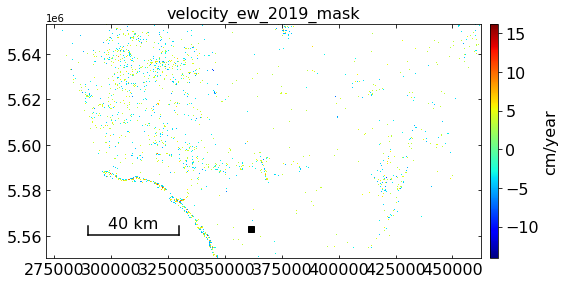

In [127]:
view.main('velocity_ew_2019_mask.h5 --noverbose'.split())

In [128]:
!save_gdal.py velocity_ew_2019_mask.h5 -o /home/micromamba/raw/velocity_ew_2019_mask.tif

read metadata from file: velocity_ew_2019_mask.h5
read data     from file: velocity_ew_2019_mask.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/raw/velocity_ew_2019_mask.tif
